<a href="https://colab.research.google.com/github/mridul7ahuja/time-series-and-statistics/blob/main/Time%20Series%20Analysis%20of%20Walmart%20Sales%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler




import time
from tqdm import tqdm_notebook as tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/term_paper.zip"

Archive:  /content/drive/MyDrive/term_paper.zip
   creating: term_paper/
   creating: term_paper/.ipynb_checkpoints/
  inflating: term_paper/.ipynb_checkpoints/term-checkpoint.ipynb  
  inflating: term_paper/calendar.csv  
  inflating: term_paper/sales_train_evaluation.csv  
  inflating: term_paper/sales_train_validation.csv  
  inflating: term_paper/sell_prices.csv  
  inflating: term_paper/term.ipynb   


In [ ]:
train = pd.read_csv("term_paper/sales_train_evaluation.csv")
print(train.head())

                              id        item_id  ... d_1940 d_1941
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  ...      0      1
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  ...      0      0
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  ...      0      1
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  ...      2      6
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  ...      1      0

[5 rows x 1947 columns]


In [ ]:
calendar = pd.read_csv("term_paper/calendar.csv")
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
sell_prices = pd.read_csv("term_paper/sell_prices.csv")
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
series_cols = train.columns[train.columns.str.contains("d_")].values
level_cols = train.columns[train.columns.str.contains("d_")==False].values

In [ ]:
series = calendar.columns[calendar.columns.str.contains("event")].values
print(series)

['event_name_1' 'event_type_1' 'event_name_2' 'event_type_2']


In [ ]:
train.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1


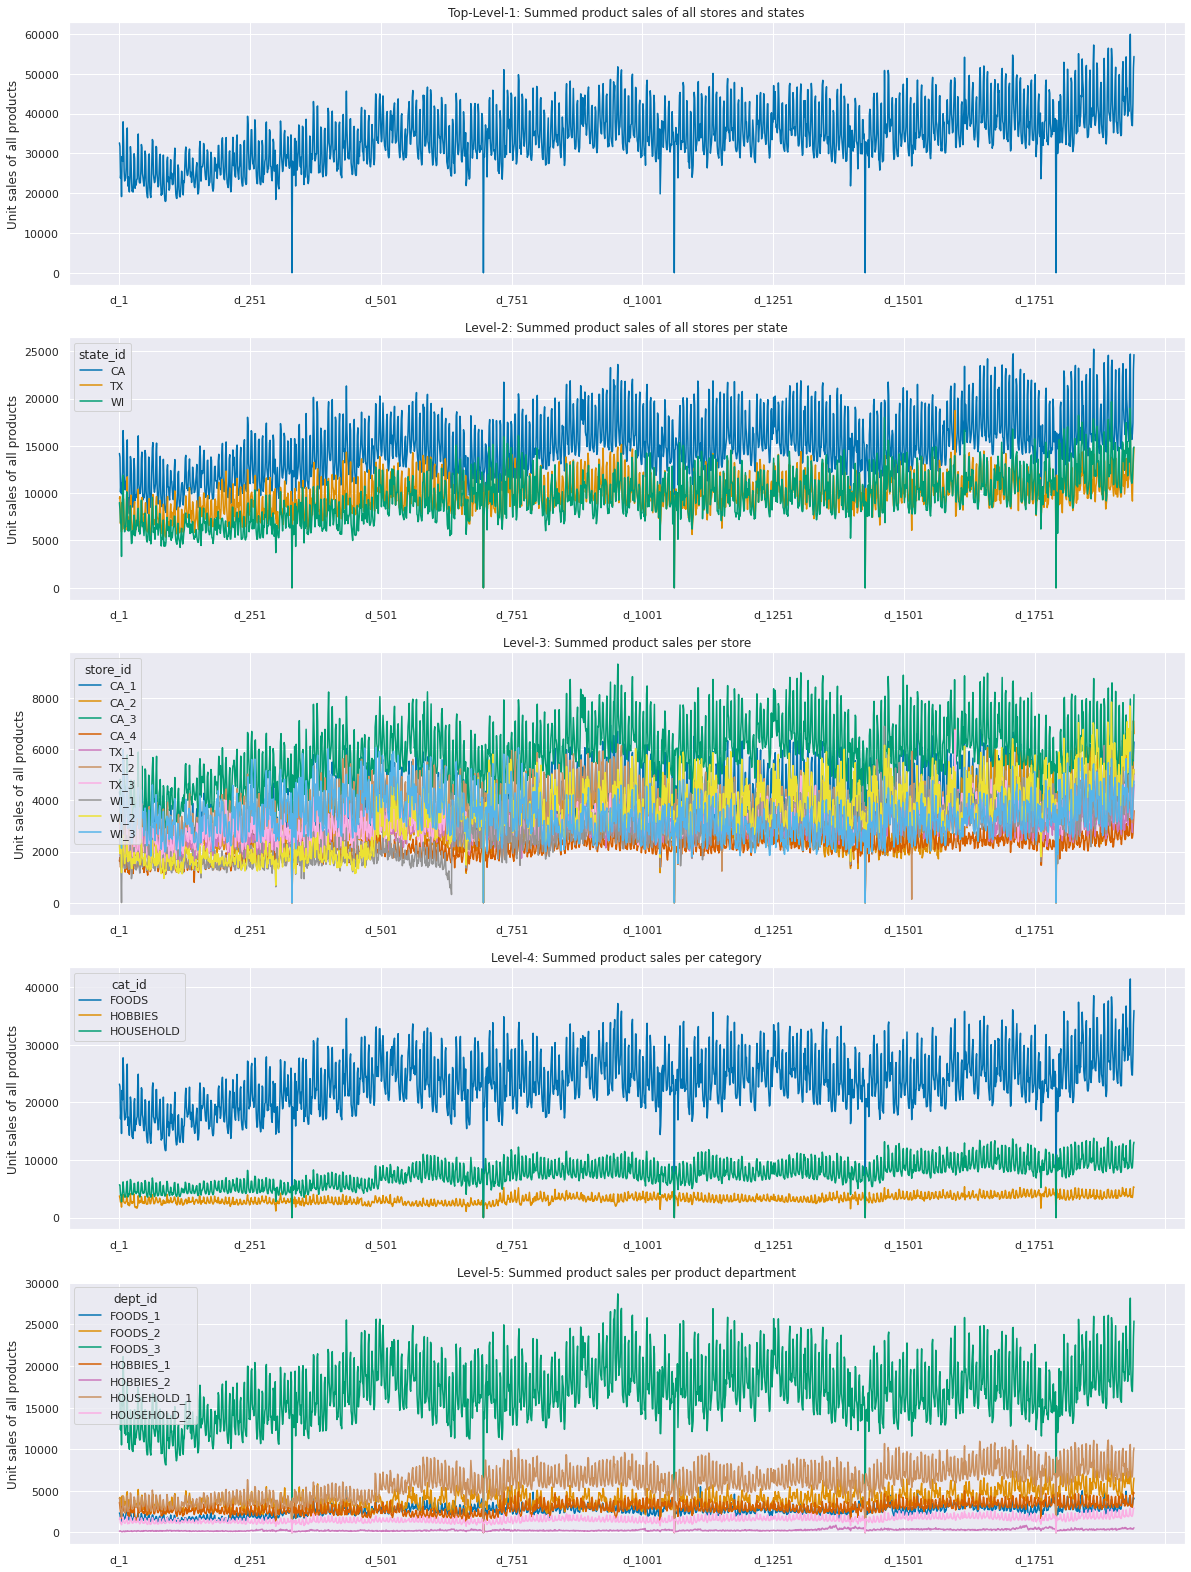

In [ ]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-5: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");


In [ ]:
train[series_cols].sum()

d_1       32631
d_2       31749
d_3       23783
d_4       25412
d_5       19146
          ...  
d_1937    37096
d_1938    36963
d_1939    42552
d_1940    51518
d_1941    54338
Length: 1941, dtype: int64

In [ ]:
pd.crosstab(calendar["weekday"],calendar["d"],rownames=['weekday'],colnames=['d'])

d,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,d_1007,d_1008,d_1009,d_101,d_1010,d_1011,d_1012,d_1013,d_1014,d_1015,d_1016,d_1017,d_1018,d_1019,d_102,d_1020,d_1021,d_1022,d_1023,d_1024,d_1025,d_1026,d_1027,d_1028,d_1029,d_103,d_1030,d_1031,d_1032,d_1033,...,d_963,d_964,d_965,d_966,d_967,d_968,d_969,d_97,d_970,d_971,d_972,d_973,d_974,d_975,d_976,d_977,d_978,d_979,d_98,d_980,d_981,d_982,d_983,d_984,d_985,d_986,d_987,d_988,d_989,d_99,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Friday,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
Monday,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
Saturday,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
Sunday,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
Thursday,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Tuesday,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
Wednesday,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
import os
import math
import numpy as np                                 # linear algebra
import pandas as pd                                # dataframes
import matplotlib.pyplot as plt                    # visualizations
import seaborn as sns
import ipywidgets as widgets                       # interative jupyter
from IPython.display import clear_output

from scipy import stats                            # statistics
from datetime import datetime, date, timedelta     # time
from dateutil.relativedelta import relativedelta
          # time-series decomposition

from matplotlib.patches import Polygon

In [ ]:
def info_df(df):
    """
    returns the dataframe describing nulls and unique counts
    inp: dataframe
    returns: dataframe with unique and null counts
    """
    return pd.DataFrame({
        "uniques": df.nunique(),
        "nulls": df.isnull().sum(),
        "nulls (%)": df.isnull().sum() / len(df)
    }).T


In [ ]:
print("Final len of the Dataset after unpivoting would be = {}".format(train.shape[0] * 1913))

# for unpivoting, we need to define the variables into two sets, id_vars and value_vars
value_variables = [col for col in train.columns if col.startswith("d_")]
identifier_variables = [col for col in train.columns if col not in value_variables] 

# converting the df from wide to long
sales_sample_df = pd.melt(train, 
                          id_vars = identifier_variables, 
                          value_vars = value_variables)

print("Actual Shape after unpivoting = {}".format(sales_sample_df.shape))

# changing the variable name to apt names
sales_sample_df = sales_sample_df.rename(columns = {"variable": "day_number", "value": "units_sold"})

Final len of the Dataset after unpivoting would be = 58327370
Actual Shape after unpivoting = (59181090, 8)


In [ ]:
# creating a date column
earliest_date = date(2011, 1, 29)
date_dict = {}                    # a dictionary to map the day_number values to real dates
for i in list(sales_sample_df["day_number"].unique()):
    dn_int = int(i[2:]) - 1                                   # indexing the string value to delete "d_" from the day_number and converting it to int
                                                              # subtracting 1 because "d_1" would be our zeroth day. 
    date_ = earliest_date + timedelta(days = dn_int)
    date_dict[i] = date_

# mapping the dictionary to dataframe
sales_sample_df["date"] = sales_sample_df["day_number"].map(date_dict)
sales_sample_df["date"] = pd.to_datetime(sales_sample_df["date"])

In [ ]:
sales_sample_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22


In [ ]:
statewise_df = sales_sample_df.groupby(["state_id", "date"]).agg({
    "units_sold": "sum"
}).reset_index()

# extracting month and year from date for group by purposes
statewise_df["day"] = statewise_df["date"].dt.day
statewise_df["month"] = statewise_df["date"].dt.month
statewise_df["year"] = statewise_df["date"].dt.year

# aggregating on month level for each state
statewise_df = statewise_df.groupby(["month", "year", "state_id"]).agg({
    "units_sold": "sum", 
    "day": "first"
}).reset_index()

statewise_df["date"] = pd.to_datetime(statewise_df["year"].astype("str") + "-" + \
                                      statewise_df["month"].astype("str") + "-" + \
                                      statewise_df["day"].astype("str"))

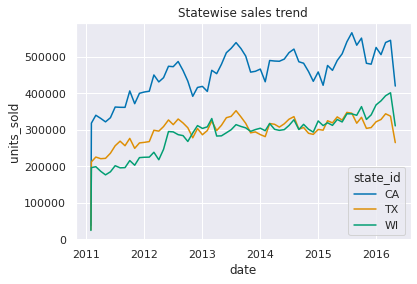

In [ ]:
sns.lineplot(x = "date", y = "units_sold", hue = "state_id", data = statewise_df)
plt.title("Statewise sales trend")
plt.show()

In [ ]:
# creating a new dataframe for storewise aggregation
storewise_df = sales_sample_df.groupby(["state_id", "store_id", "date"]).agg({
    "units_sold": "sum"
}).reset_index()

# extracting month and year from date for group by purposes
storewise_df["day"] = storewise_df["date"].dt.day
storewise_df["month"] = storewise_df["date"].dt.month
storewise_df["year"] = storewise_df["date"].dt.year

# aggregating on month level for each state and store
storewise_df = storewise_df.groupby(["month", "year", "state_id", "store_id"]).agg({
    "units_sold": "sum", 
    "day": "first"
}).reset_index()

storewise_df["date"] = pd.to_datetime(storewise_df["year"].astype("str") + "-" + \
                                      storewise_df["month"].astype("str") + "-" + \
                                      storewise_df["day"].astype("str"))

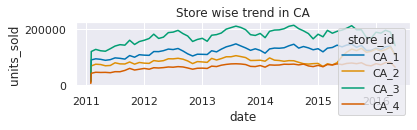

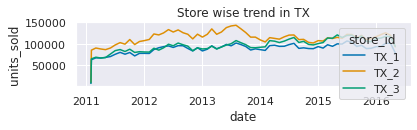

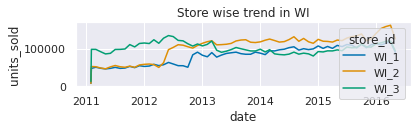

In [ ]:
state_list = list(storewise_df["state_id"].unique())
for i in range(1, 4):
    plt.subplot(3, 1, i)
    sns.lineplot(x = "date", 
                 y = "units_sold", 
                 hue = "store_id", 
                 data = storewise_df[storewise_df["state_id"] == state_list[i - 1]])
    plt.title("Store wise trend in {}".format(state_list[i - 1]))
    plt.show()

In [ ]:
# creating a new dataframe for storewise aggregation
catwise_df = sales_sample_df.groupby(["state_id", "cat_id", "date"]).agg({
    "units_sold": "sum"
}).reset_index()

# extracting month and year from date for group by purposes
catwise_df["day"] = catwise_df["date"].dt.day
catwise_df["month"] = catwise_df["date"].dt.month
catwise_df["year"] = catwise_df["date"].dt.year

# aggregating on month level for each state and store
catwise_df = catwise_df.groupby(["month", "year", "state_id", "cat_id"]).agg({
    "units_sold": "sum", 
    "day": "first"
}).reset_index()

catwise_df["date"] = pd.to_datetime(catwise_df["year"].astype("str") + "-" + \
                                    catwise_df["month"].astype("str") + "-" + \
                                    catwise_df["day"].astype("str"))

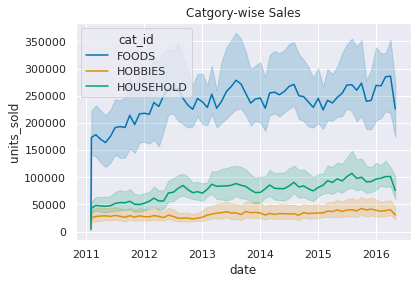

In [ ]:
sns.lineplot(x = "date", y = "units_sold", hue = "cat_id", data = catwise_df)
plt.title("Catgory-wise Sales")
plt.show()

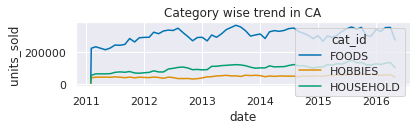

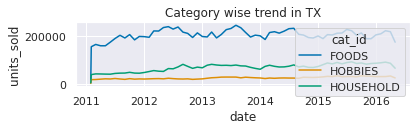

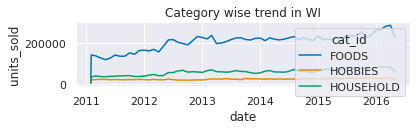

In [ ]:
for i in range(1, 4):
    plt.subplot(3, 1, i)
    sns.lineplot(x = "date", 
                 y = "units_sold", 
                 hue = "cat_id", 
                 data = catwise_df[catwise_df["state_id"] == state_list[i - 1]])
    plt.title("Category wise trend in {}".format(state_list[i - 1]))
    plt.show()

In [ ]:
sales_sample_df["day_of_week"] = sales_sample_df["date"].dt.weekday
sales_sample_df["month"] = sales_sample_df["date"].dt.month
sales_sample_df["year"] = sales_sample_df["date"].dt.year

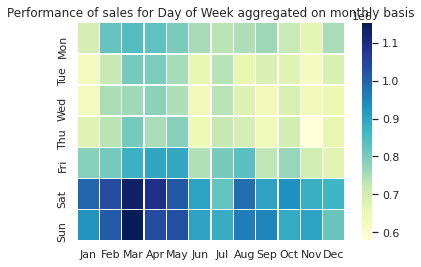

In [ ]:
week_month_pivot = sales_sample_df.pivot_table(index = "day_of_week", 
                                               columns = "month", 
                                               values = "units_sold", 
                                               aggfunc = "sum")

week_month_pivot.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
week_month_pivot.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

sns.heatmap(week_month_pivot, linewidth = 0.2, cmap="YlGnBu")
plt.title("Performance of sales for Day of Week aggregated on monthly basis")
plt.show()

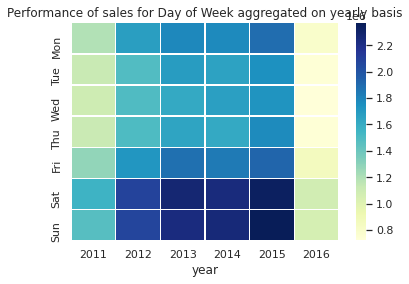

In [ ]:
week_year_pivot = sales_sample_df.pivot_table(index = "day_of_week", 
                                               columns = "year", 
                                               values = "units_sold", 
                                               aggfunc = "sum")

week_year_pivot.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

sns.heatmap(week_year_pivot, linewidth = 0.2, cmap="YlGnBu")
plt.title("Performance of sales for Day of Week aggregated on yearly basis")
plt.show()

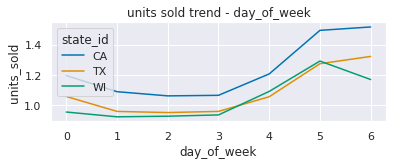

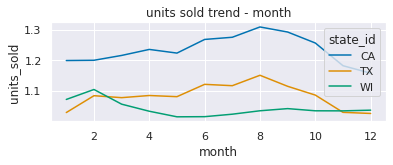

In [ ]:
temp_list = ["day_of_week", "month"]
for i in range(0, 2):
    plt.subplot(2, 1, i + 1)
    tempdf = sales_sample_df.groupby([temp_list[i], "state_id"]).agg({
        "units_sold": "mean"
    }).reset_index()
    sns.lineplot(x = temp_list[i], y = "units_sold", hue = "state_id", data = tempdf)
    plt.title("units sold trend - {}".format(temp_list[i]))
    plt.show()

In [ ]:
import scipy
import scipy.stats
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['norm','lognorm']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))

        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        
        self.DistributionName = sel_dist
        self.PValue = p
        self.Param=self.params[sel_dist]
        self.isFitted = True
        print("Distribution is",self.DistributionName," with parameters  (local shift,scale) is",self.Param,"\n")
        return self.DistributionName,self.PValue
        
dis=Distribution()

In [ ]:
collective=train[series_cols].sum()
print(collective.shape)

mean=collective.mean()
std=collective.std()
total=collective.size
print(mean,std,total)

(1941,)
34480.76919113859 7425.906822426443 1941


99% confidence interval ( 34046.61013269306 , 34914.928249584125 )
95% confidence interval ( 34150.40512772014 , 34811.13325455704 )
90% confidence interval ( 34203.51620750746 , 34758.02217476972 )
Distribution is lognorm  with parameters  (local shift,scale) is (0.01700033214654769, -402153.15063128667, 436572.4843321473) 



(array([  5.,   0.,   1., 131., 378., 681., 406., 263.,  66.,  10.]),
 array([1.1000e+01, 6.0020e+03, 1.1993e+04, 1.7984e+04, 2.3975e+04,
        2.9966e+04, 3.5957e+04, 4.1948e+04, 4.7939e+04, 5.3930e+04,
        5.9921e+04]),
 <a list of 10 Patch objects>)

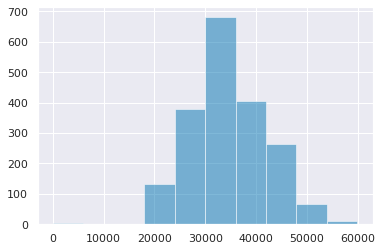

In [ ]:
z_005=2.5758
z_025=1.9600
z_05=1.6449

print("99% confidence interval (",mean- std*z_005/(total**0.5),",",mean+std*z_005/(total**0.5),")" )
print("95% confidence interval (",mean- std*z_025/(total**0.5),",",mean+std*z_025/(total**0.5),")" )
print("90% confidence interval (",mean- std*z_05/(total**0.5),",",mean+ std*z_05/(total**0.5),")" )

dis.Fit(collective)
plt.hist(collective, alpha=0.5)

In [ ]:
state_wise=train.groupby("state_id")[series_cols].sum().to_numpy()
print(state_wise)




[[14195 13805 10108 ... 17430 23103 24644]
 [ 9438  9630  6778 ... 12303 13681 14815]
 [ 8998  8314  6897 ... 12819 14734 14879]]


99% confidence interval day sale CA ( 14850.165490062442 , 15234.035437294591 )
Distribution is lognorm  with parameters  (local shift,scale) is (0.03708017844498253, -73400.46048044444, 88381.50474205957) 

STD:  3282.878019730785


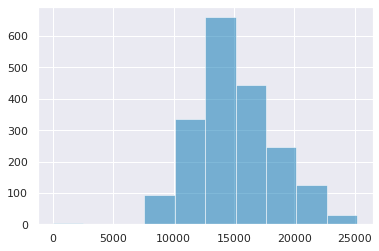

In [ ]:
CA_mean=state_wise[0].mean()
CA_std=state_wise[0].std()
print("99% confidence interval day sale CA (",CA_mean- CA_std*z_005/(total**0.5),",",CA_mean+CA_std*z_005/(total**0.5),")" )

dis=Distribution()
#print("name",dis.DistributionName)
dis.Fit(state_wise[0])
plt.hist(state_wise[0], alpha=0.5)
print("STD: ", CA_std)

99% confidence interval day sale CA ( 14850.165490062442 , 15234.035437294591 )
Distribution is lognorm  with parameters  (local shift,scale) is (0.03708017844498253, -73400.46048044444, 88381.50474205957) 



(array([  5.,   0.,   1.,  93., 335., 660., 445., 247., 125.,  30.]),
 array([5.00000e+00, 2.52690e+03, 5.04880e+03, 7.57070e+03, 1.00926e+04,
        1.26145e+04, 1.51364e+04, 1.76583e+04, 2.01802e+04, 2.27021e+04,
        2.52240e+04]),
 <a list of 10 Patch objects>)

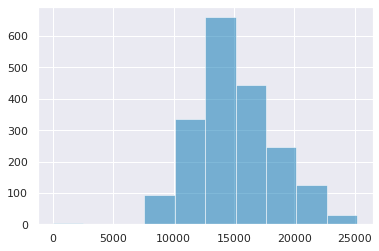

In [ ]:
CA_mean=state_wise[0].mean()
CA_std=state_wise[0].std()
print("99% confidence interval day sale CA (",CA_mean- CA_std*z_005/(total**0.5),",",CA_mean+CA_std*z_005/(total**0.5),")" )

dis=Distribution()
#print("name",dis.DistributionName)
dis.Fit(state_wise[0])
plt.hist(state_wise[0], alpha=0.5)

99% confidence interval day sale TX ( 9791.096213823694 , 10021.788896943952 )
Distribution is lognorm  with parameters  (local shift,scale) is (0.019974460397672644, -88585.01432267291, 98477.48775541678) 

STD:  1972.897186114452


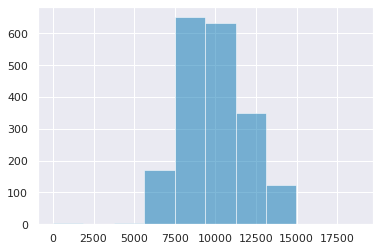

In [ ]:
TX_mean=state_wise[1].mean()
TX_std=state_wise[1].std()
print("99% confidence interval day sale TX (",TX_mean- TX_std*z_005/(total**0.5),",",TX_mean+TX_std*z_005/(total**0.5),")" )

dis=Distribution()
#print("name",dis.DistributionName)
dis.Fit(state_wise[1])
plt.hist(state_wise[1], alpha=0.5)
print("STD: ", TX_std)

99% confidence interval day sale WI ( 9379.831036368549 , 9684.62130778395 )
Distribution is norm  with parameters  (local shift,scale) is (9532.226172076249, 2606.584052416779) 

STD:  2606.584052416779


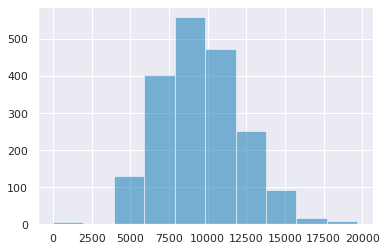

In [ ]:

WI_mean=state_wise[2].mean()
WI_std=state_wise[2].std()

print("99% confidence interval day sale WI (",WI_mean- WI_std*z_005/(total**0.5),",",WI_mean+WI_std*z_005/(total**0.5),")" )

dis=Distribution()
#print("name",dis.DistributionName)
dis.Fit(state_wise[2])
plt.hist(state_wise[2], alpha=0.5)
print("STD: ", WI_std)

In [ ]:
print("WI Mean:", WI_mean)

WI Mean: 9532.226172076249


## **Time Series Analysis**

In [ ]:
sales_sample_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29


In [ ]:
sales_sample_df['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [ ]:
hobbies = sales_sample_df.loc[sales_sample_df['cat_id']=='HOBBIES']

In [ ]:
hobbies['date'].min(), hobbies['date'].max()

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-05-22 00:00:00'))

In [ ]:
hobbies.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29


In [ ]:
cols = ['id','item_id','dept_id','cat_id','store_id','state_id','day_number']
hobbies.drop(cols, axis=1, inplace=True)

In [ ]:
hobbies.isnull().sum()

units_sold    0
date          0
dtype: int64

In [ ]:
hobbies = hobbies.groupby('date')['units_sold'].sum().reset_index()

In [ ]:
hobbies.head()

,date,units_sold
0,2011-01-29,3764
1,2011-01-30,3357
2,2011-01-31,2682
3,2011-02-01,2669
4,2011-02-02,1814


### **Indexing**

In [ ]:
hobbies = hobbies.set_index('date')
hobbies.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [ ]:
y = hobbies['units_sold'].resample('MS').mean()

In [ ]:
y['2014':]

date
2014-01-01    3316.354839
2014-02-01    3285.142857
2014-03-01    3244.032258
2014-04-01    3160.333333
2014-05-01    3219.935484
2014-06-01    3300.500000
2014-07-01    3163.419355
2014-08-01    3181.774194
2014-09-01    3036.400000
2014-10-01    3395.064516
2014-11-01    3323.200000
2014-12-01    3293.903226
2015-01-01    3327.258065
2015-02-01    3686.392857
2015-03-01    3658.096774
2015-04-01    3712.366667
2015-05-01    3870.741935
2015-06-01    3728.100000
2015-07-01    3836.870968
2015-08-01    3913.000000
2015-09-01    3817.800000
2015-10-01    4136.451613
2015-11-01    3988.133333
2015-12-01    4017.064516
2016-01-01    3792.032258
2016-02-01    3894.448276
2016-03-01    3749.709677
2016-04-01    4040.566667
2016-05-01    4166.272727
Freq: MS, Name: units_sold, dtype: float64

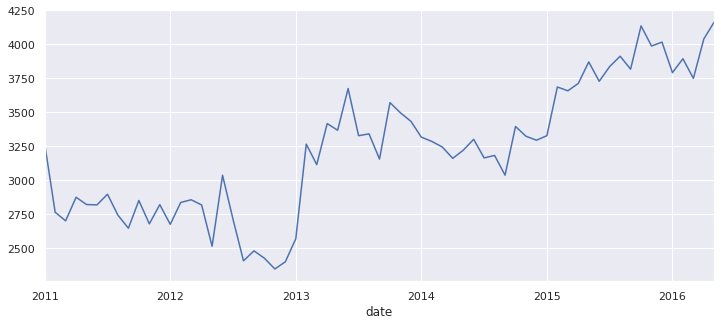

In [ ]:
y.plot(figsize=(12,5))
plt.show()

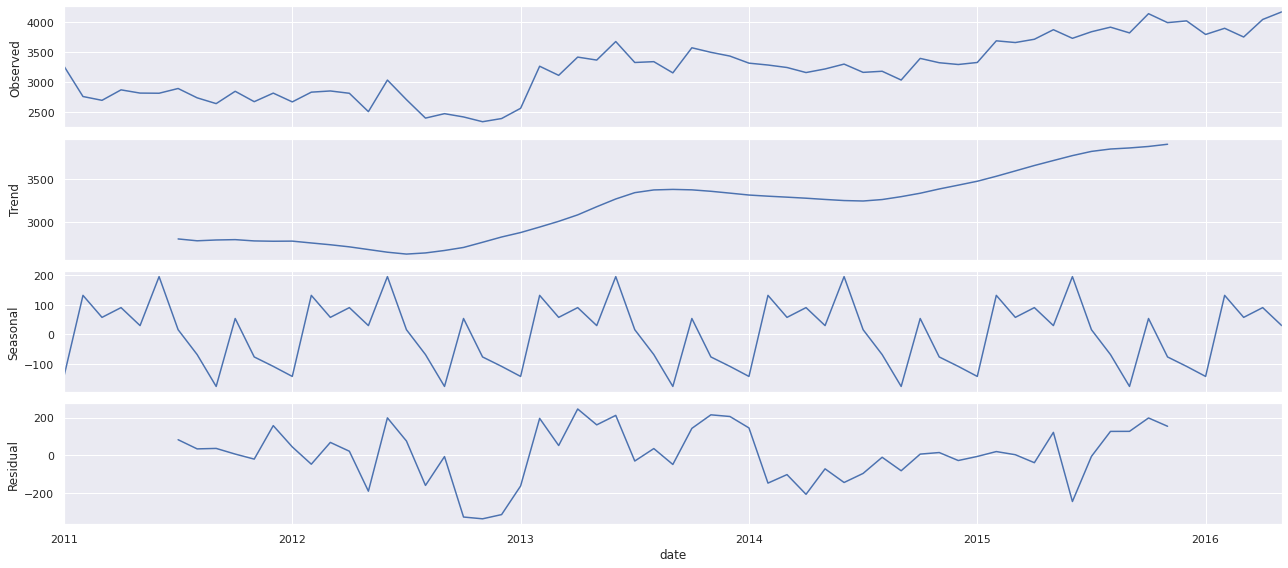

In [ ]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1218.9590492077457
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:949.7042668066368
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:798.9171897770718
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:623.342952572555
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:804.9530350972975
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:752.6944335116586
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:634.9228366775566
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:612.7106100128658
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1159.0606487880586
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:876.8242498572583
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:748.4475941306695
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:576.9600747963897
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:777.3245946340021
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:713.2042636507546
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:606.1019391436289
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:576.9615114266398
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:849.989013746519
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:692.429027

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5552      0.323     -1.721      0.085      -1.188       0.077
ma.L1          0.3099      0.347      0.892      0.372      -0.371       0.991
ma.S.L12      -0.7465      0.345     -2.164      0.030      -1.423      -0.071
sigma2       2.75e+04   1.08e+04      2.548      0.011    6346.770    4.87e+04


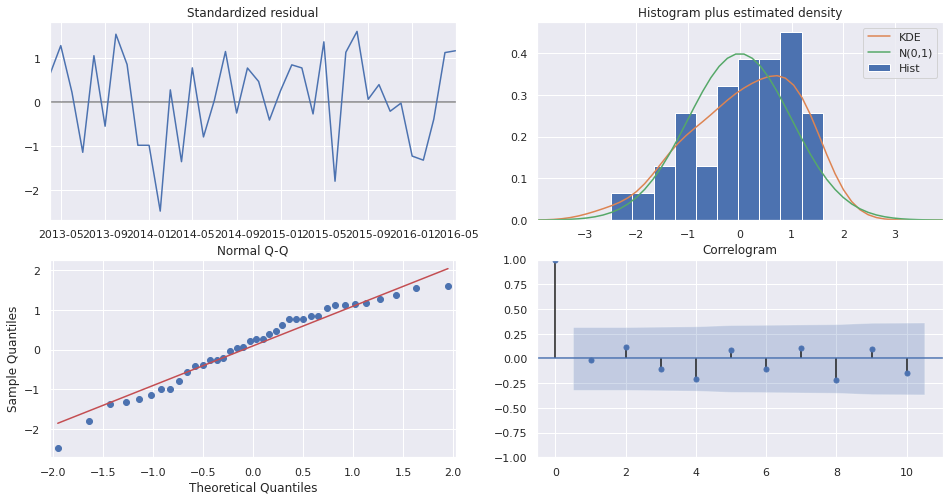

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### **Validating Forecasts**

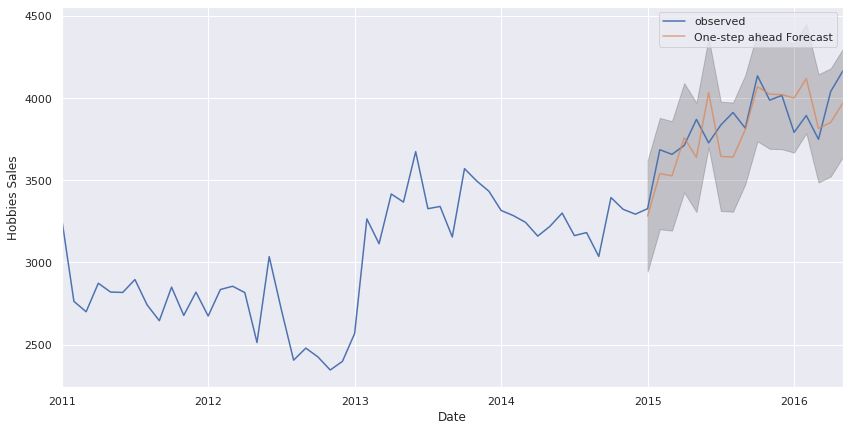

In [ ]:
# From 2015-01-01 to the end

pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Hobbies Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34417.06


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 185.52


### **Producing and visualizing forecasts**

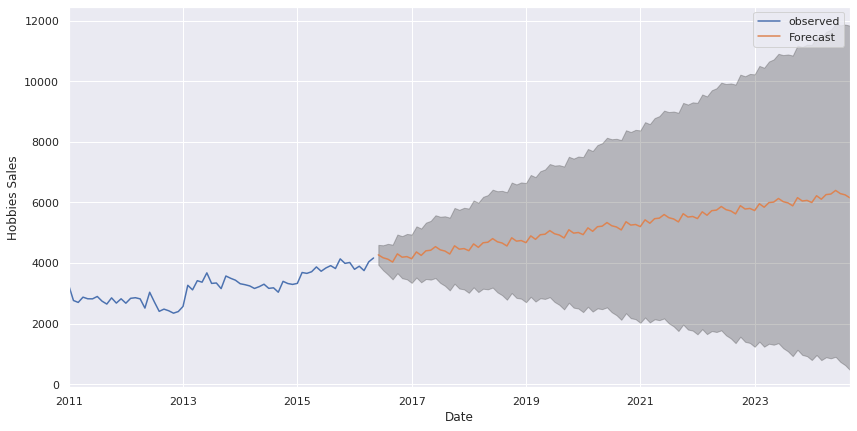

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Hobbies Sales')
plt.legend()
plt.show()

### **Time series of hobbies and household items**

In [ ]:
household = sales_sample_df.loc[sales_sample_df['cat_id']=='HOUSEHOLD'].copy(deep=True)

In [ ]:
household.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date
565,HOUSEHOLD_1_001_CA_1_evaluation,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,3,2011-01-29
566,HOUSEHOLD_1_002_CA_1_evaluation,HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,1,2011-01-29
567,HOUSEHOLD_1_003_CA_1_evaluation,HOUSEHOLD_1_003,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29
568,HOUSEHOLD_1_004_CA_1_evaluation,HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,4,2011-01-29
569,HOUSEHOLD_1_005_CA_1_evaluation,HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_1,0,2011-01-29


In [ ]:
household.drop(cols,axis=1,inplace=True)

In [ ]:
household.head()

,units_sold,date
565,3,2011-01-29
566,1,2011-01-29
567,0,2011-01-29
568,4,2011-01-29
569,0,2011-01-29


In [ ]:
household.isnull().sum()

units_sold    0
date          0
dtype: int64

In [ ]:
household = household.sort_values('date')
hobbies = hobbies.sort_values('date')

household = household.groupby('date')['units_sold'].sum().reset_index()
hobbies = hobbies.groupby('date')['units_sold'].sum().reset_index()

household = household.set_index('date')
hobbies = hobbies.set_index('date')

y_household = household['units_sold'].resample('MS').mean()
y_hobbies = hobbies['units_sold'].resample('MS').mean()

household = pd.DataFrame({'date': y_household.index, 'units_sold': y_household.values})
hobbies = pd.DataFrame({'date': y_hobbies.index, 'units_sold': y_hobbies.values})

store = hobbies.merge(household, how='inner', on='date')
store.rename(columns={'units_sold_x': 'hobbies_sales', 'units_sold_y': 'household_sales'}, inplace=True)
store.head()

,date,hobbies_sales,household_sales
0,2011-01-01,3267.666667,5083.333333
1,2011-02-01,2762.928571,4598.678571
2,2011-03-01,2699.709677,4676.193548
3,2011-04-01,2873.300000,4731.533333
4,2011-05-01,2819.774194,4528.903226


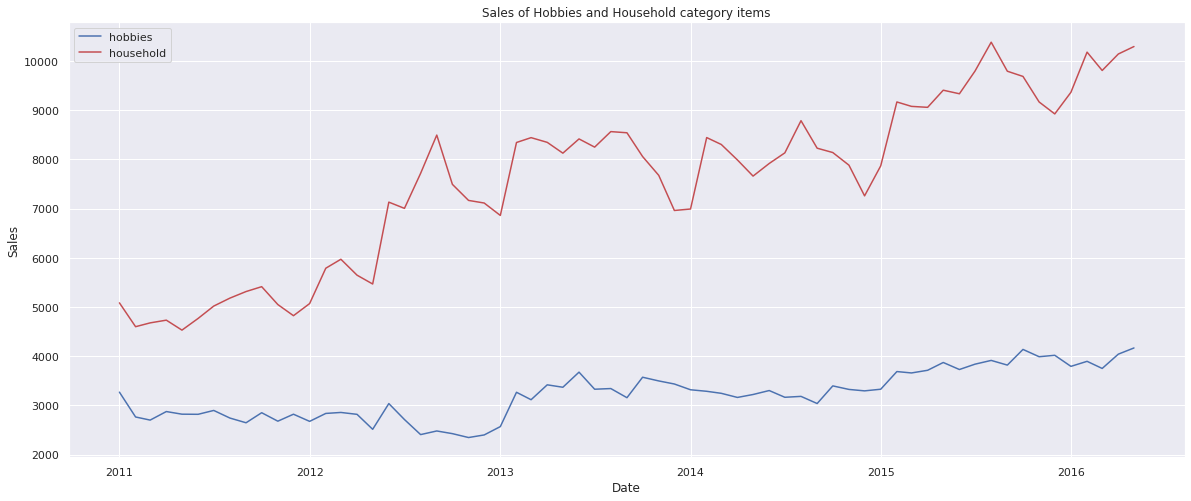

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(store['date'], store['hobbies_sales'], 'b-', label = 'hobbies')
plt.plot(store['date'], store['household_sales'], 'r-', label = 'household')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Hobbies and Household category items')
plt.legend();

### **Time series with Prophet**

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

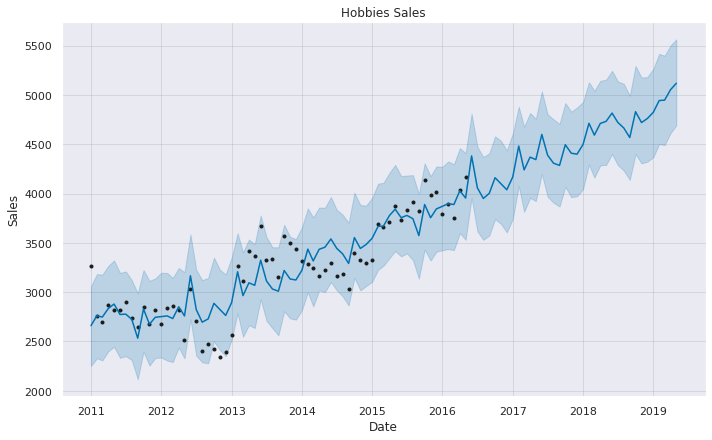

In [ ]:
from fbprophet import Prophet

hobbies = hobbies.rename(columns={'date': 'ds', 'units_sold': 'y'})
hobbies_model = Prophet(interval_width=0.95)
hobbies_model.fit(hobbies)

household = household.rename(columns={'date': 'ds', 'units_sold': 'y'})
household_model = Prophet(interval_width=0.95)
household_model.fit(household)

hobbies_forecast = hobbies_model.make_future_dataframe(periods=36, freq='MS')
hobbies_forecast = hobbies_model.predict(hobbies_forecast)

household_forecast = household_model.make_future_dataframe(periods=36, freq='MS')
household_forecast = household_model.predict(household_forecast)

plt.figure(figsize=(18, 6))
hobbies_model.plot(hobbies_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Hobbies Sales');

<Figure size 1296x432 with 0 Axes>

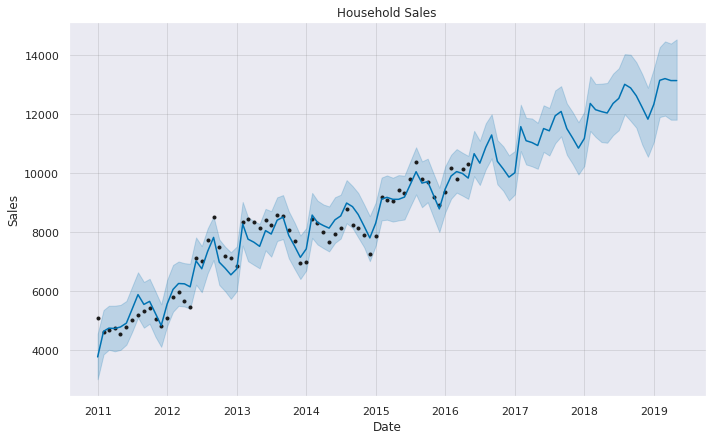

In [ ]:
plt.figure(figsize=(18, 6))
household_model.plot(household_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Household Sales');

### **Compare Forecasts**

In [ ]:
hobbies_names = ['hobbies_%s' % column for column in hobbies_forecast.columns]
household_names = ['household_%s' % column for column in household_forecast.columns]

merge_hobbies_forecast = hobbies_forecast.copy()
merge_household_forecast = household_forecast.copy()

merge_hobbies_forecast.columns = hobbies_names
merge_household_forecast.columns = household_names

forecast = pd.merge(merge_hobbies_forecast, merge_household_forecast, how = 'inner', left_on = 'hobbies_ds', right_on = 'household_ds')
forecast = forecast.rename(columns={'hobbies_ds': 'Date'}).drop('household_ds', axis=1)
forecast.head()

,Date,hobbies_trend,hobbies_yhat_lower,hobbies_yhat_upper,hobbies_trend_lower,hobbies_trend_upper,hobbies_additive_terms,hobbies_additive_terms_lower,hobbies_additive_terms_upper,hobbies_yearly,hobbies_yearly_lower,hobbies_yearly_upper,hobbies_multiplicative_terms,hobbies_multiplicative_terms_lower,hobbies_multiplicative_terms_upper,hobbies_yhat,household_trend,household_yhat_lower,household_yhat_upper,household_trend_lower,household_trend_upper,household_additive_terms,household_additive_terms_lower,household_additive_terms_upper,household_yearly,household_yearly_lower,household_yearly_upper,household_multiplicative_terms,household_multiplicative_terms_lower,household_multiplicative_terms_upper,household_yhat
0,2011-01-01,2629.809772,2251.581429,3060.083658,2629.809772,2629.809772,30.515581,30.515581,30.515581,30.515581,30.515581,30.515581,0.0,0.0,0.0,2660.325353,4103.953668,3003.077158,4540.757974,4103.953668,4103.953668,-341.634807,-341.634807,-341.634807,-341.634807,-341.634807,-341.634807,0.0,0.0,0.0,3762.318861
1,2011-02-01,2637.118993,2329.294984,3183.309633,2637.118993,2637.118993,123.938846,123.938846,123.938846,123.938846,123.938846,123.938846,0.0,0.0,0.0,2761.057839,4243.565291,3846.257412,5349.666036,4243.565291,4243.565291,386.494540,386.494540,386.494540,386.494540,386.494540,386.494540,0.0,0.0,0.0,4630.059830
2,2011-03-01,2643.720870,2307.760853,3177.287657,2643.720870,2643.720870,103.402402,103.402402,103.402402,103.402402,103.402402,103.402402,0.0,0.0,0.0,2747.123272,4369.666112,4004.623096,5496.904055,4369.666112,4369.666112,367.843332,367.843332,367.843332,367.843332,367.843332,367.843332,0.0,0.0,0.0,4737.509444
3,2011-04-01,2651.030091,2400.458735,3266.478791,2651.030091,2651.030091,182.585079,182.585079,182.585079,182.585079,182.585079,182.585079,0.0,0.0,0.0,2833.615170,4509.277735,3952.221573,5498.314998,4509.277735,4509.277735,215.512681,215.512681,215.512681,215.512681,215.512681,215.512681,0.0,0.0,0.0,4724.790416
4,2011-05-01,2658.103531,2445.538222,3321.197539,2658.103531,2658.103531,221.035339,221.035339,221.035339,221.035339,221.035339,221.035339,0.0,0.0,0.0,2879.138871,4644.385757,3999.188801,5524.738672,4644.385757,4644.385757,132.807613,132.807613,132.807613,132.807613,132.807613,132.807613,0.0,0.0,0.0,4777.193370


### **Trend and Forecast Visualization**

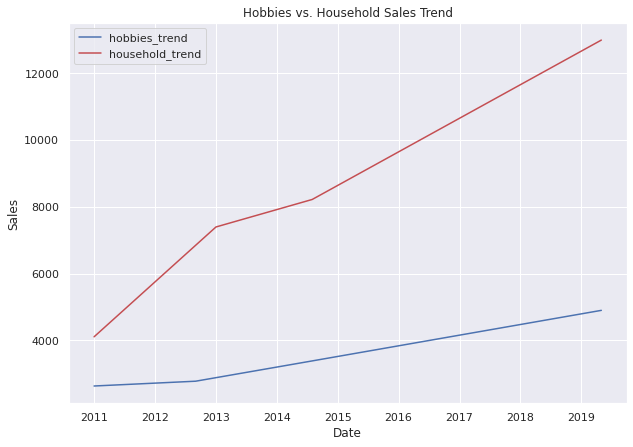

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['hobbies_trend'], 'b-', label='hobbies_trend')
plt.plot(forecast['Date'], forecast['household_trend'], 'r-', label='household_trend')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Hobbies vs. Household Sales Trend');

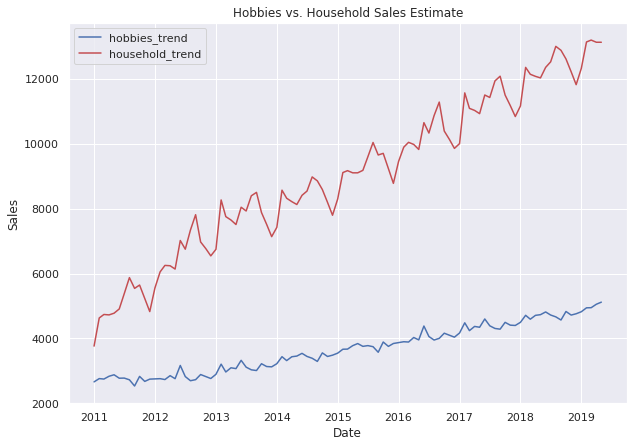

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['hobbies_yhat'], 'b-', label='hobbies_trend')
plt.plot(forecast['Date'], forecast['household_yhat'], 'r-', label='household_trend')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Hobbies vs. Household Sales Estimate');

### **Trends and Patterns**

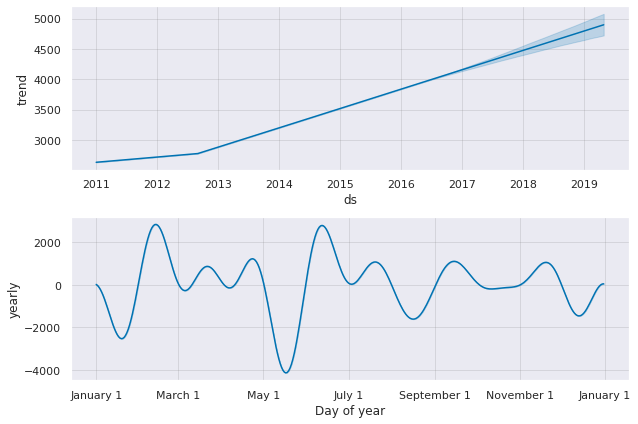

In [ ]:
hobbies_model.plot_components(hobbies_forecast);

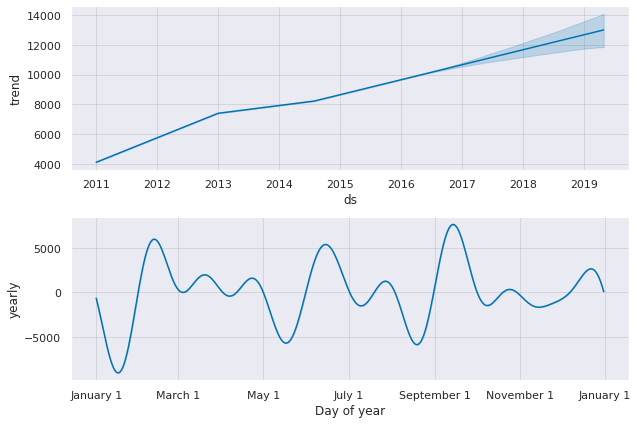

In [ ]:
household_model.plot_components(household_forecast);